<a href="https://colab.research.google.com/github/PETEROA/Layer-Configuration/blob/main/Layer_Config.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Exploring Layer configuration choices in transformer language models. I investigate how diff architectural decisions affect model performance when parameter budgets are held approximately constant.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import math
import json
import time
import os
from typing import Dict, List, Optional, Tuple
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass
import logging

In [ ]:
#Configure Logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

Config dataclass to centralize architectural parameters for transformer variants; standard settings (layers, dimensions, heads) and experimental features (bottleneck patterns,skip connection types)  

In [ ]:
@dataclass
class ModelConfig:

  vocab_size: int = 10000
  max_seq_len: int = 512
  n_layers: int = 6
  n_heads: int = 8
  d_model: int = 512
  d_ff: int = None # Will be set to 4 * d_model if None
  dropout: float = 0.1
  layer_norm_eps: float = 1e-5

  #Architecture Specific Configs
  use_bottleneck: bool = False
  bottleneck_pattern: str = "hourglass"
  bottleneck_dims: List[int] = None

  skip_connection_type: str = "residual"
  skip_frequency: int = 1 # Skip every N layers

  def __post_init__(self):
    if self.d_ff is None:
      self.d_ff = 4 * self.d_model

    if self.use_bottleneck and self.bottleneck_dims is None:
      self.bottleneck_dims = self._generate_bottleneck_dims()

  def _generate_bottleneck_dims(self) -> List[int]:
    #Generate bottleneck dimension based on pattern
    dims = []
    if self.bottleneck_pattern == "hourglass":
      #Wide -> Narrow -> Wide
      for i in range(self.n_layers):
        if i < self.n_layers // 4:
          dims.append(self.d_model)
        elif i < 3 * self.n_layers // 4:
          dims.append(self.d_model // 2)
        else:
          dims.append(self.d_model)

    elif self.bottleneck_pattern == "inverted":
      # Narrow -> Wide -> Narrow
      for i in range(self.n_layers):
        if i < self.n_layers // 4:
          dims.append(self.d_model // 2)
        elif i < 3 * self.n_layers // 4:
          dims.append(self.d_model)
        else:
          dims.append(self.d_model // 2)
    else:
      dims = [self.d_model] * self.n_layers
    return dims

  def count_parameters(self) -> int:
    #Estimate parameter count
    #Embedding Parameters
    params = self.vocab_size * self.d_model

    #Transformer Layers
    for i in range(self.n_layers):
      d_model = self.bottleneck_dims[i] if self.use_bottleneck else self.d_model

      #Attention
      params += 3 * d_model * d_model #QKV projections
      params += d_model * d_model # Output projection
      params += 2 * d_model #Layer norm

      #FFN
      d_ff = self.d_ff if not self.use_bottleneck else 4 * d_model
      params += 4 * d_model * d_ff    # Up Projection
      params += d_ff * d_model        #down projection
      params += 2 * d_model #Layer norm

      #Highway gates if applicable
      if self.skip_connection_type == "highway":
        params += 2 * d_model  #Transforms and carry gates

    #Output Layer
    params += self.d_model * self.vocab_size

    return params


attempt at implementing SDP multi head attention, maintaining consistency accross all architectural variants to isolate effects of layer config changes. handles core attention mechanisms with configurable head counts, dropout, and proper scaling, while maintaining compatibility with input dimensions required for bottleneck architecture.

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_model: int, n_heads: int, dropout: float = 0.1):
    super().__init__()
    assert d_model % n_heads == 0

    self.d_model = d_model
    self.n_heads = n_heads
    self.d_k = d_model // n_heads

    self.w_q = nn.Linear(d_model, d_model)
    self.w_k = nn.Linear(d_model, d_model)
    self.w_v = nn.Linear(d_model, d_model)
    self.w_o = nn.Linear(d_model, d_model)

    self.dropout = nn.Dropout(dropout)
    self.scale = math.sqrt(self.d_k)

  def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None) -> torch.Tensor:
    batch_size, seq_len, d_model = x.shape

    #Linear projections
    q = self.w_q(x).reshape(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
    k = self.w_k(x).reshape(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
    v = self.w_v(x).reshape(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)

    #Attention
    scores = torch.matmul(q, k.transpose(-2, -1)) / self.scale
    if mask is not None:
      scores = scores.masked_fill(mask == 0, -1e9)


    attn_weights = F.softmax(scores, dim=-1)
    attn_weights = self.dropout(attn_weights)

    out = torch.matmul(attn_weights, v)
    out = out.transpose(1, 2).contiguous().reshape(batch_size, seq_len, d_model)


    return self.w_o(out)

Feed-Forward network implementation using GeLu activation that adapts to variable layer dimensions in bottleneck architectures. attempts to provide consistent feed forward computation accross model variants, to enasure that differences in performance can be attributed to structural choices rather than computational variations.  

In [ ]:
class Feedforward(nn.Module):
  def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1):
    super().__init__()
    self.Linear1 = nn.Linear(d_model, d_ff)
    self.Linear2 = nn.Linear(d_ff, d_model)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.Linear2(self.dropout(F.relu(self.Linear1(x))))


module implementing learnable gating mechanism for highway style skip connections, featuring seperate transformer and carry gates that control info flow between layers. A key goal of this class is to. study whether learnable skip connections improve training dynamics and final performance compared to fixed residual connections

In [ ]:
class HighwayGate(nn.Module):
  def __init__(self, d_model: int):
    super().__init__()
    self.transform_gate = nn.Linear(d_model, d_model)
    self.carry_gate = nn.Linear(d_model, d_model)

  def forward(self, x: torch.Tensor, transformed: torch.Tensor) -> torch.Tensor:
    t = torch.sigmoid(self.transform_gate(x))
    c = torch.sigmoid(self.carry_gate(x))
    return t * transformed + c * x


handles variable layer dimensions, diff skip connection types and bottleneck patterns within a unified interface.manages input/output dimension projections for bottleneck architectures, implements diff skip connection strategies and coordinates attention and FF computations.

In [ ]:
class TransformerLayer(nn.Module):
  def __init__(self, config: ModelConfig, layer_idx: int):
    super().__init__()
    self.layer_idx = layer_idx
    self.config = config

    d_model = config.bottleneck_dims[layer_idx] if config.use_bottleneck else config.d_model
    d_ff = 4 * d_model if config.use_bottleneck else config.d_ff

    self.attention = MultiHeadAttention(d_model, config.n_heads, config.dropout)
    self.feed_forward = Feedforward(d_model, d_ff, config.dropout)

    self.norm1 = nn.LayerNorm(d_model, eps=config.layer_norm_eps)
    self.norm2 = nn.LayerNorm(d_model, eps=config.layer_norm_eps)
    self.dropout = nn.Dropout(config.dropout)

    # Dimension adaptation for bottleneck architectures
    self.input_projection = None
    self.output_projection = None

    if config.use_bottleneck:
      prev_d_model = config.bottleneck_dims[layer_idx - 1] if layer_idx > 0 else config.d_model
      next_d_model = config.bottleneck_dims[layer_idx + 1] if layer_idx < len(config.bottleneck_dims) - 1 else config.d_model

      if prev_d_model != d_model:
        self.input_projection = nn.Linear(prev_d_model, d_model)
      if d_model != next_d_model:
        self.output_projection = nn.Linear(d_model, next_d_model)

        # Highway Connections
    if config.skip_connection_type == "highway":
      self.highway_gate = HighwayGate(d_model)

  def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None, skip_connections: Optional[List[torch.Tensor]] = None) -> Tuple[torch.Tensor, torch.Tensor]:

    # Input Projection for Bottleneck
    if self.input_projection is not None:
      x = self.input_projection(x)

    #Store input for potential skip connection
    residual = x

    # self attention block
    attn_out = self.attention(self.norm1(x), mask)
    x = residual + self.dropout(attn_out)

    # Feed Forward Block
    residual = x
    ff_out = self.feed_forward(self.norm2(x))

    if self.config.skip_connection_type == "highway":
      x = self.highway_gate(residual, ff_out)
    else:
      x = residual + self.dropout(ff_out)

    # Dense Connections  (simplified - connect to previous layer)
    if (self.config.skip_connection_type == "dense" and
        skip_connections is not None and
        len(skip_connections) > 0):
      # Simple dense connection to previous layer
      prev_connection = skip_connections[-1]
      if prev_connection.shape[-1] == x.shape[-1]:
        x = x + prev_connection

    # Output Projection for Bottleneck
    output = x
    if self.output_projection is not None:
      output = self.output_projection(x)

    return output, attn_out

    return x, output # Return both projected output and current layer state


Assembles individual transformer layers into a complete language model, managing embeddings, position encoding, layer interactions and output projections... handles coordination of skip connections across layers... integrates all architectural components into a functional model while preserving the experimental flexibility needed for systematic architectural comparison

In [ ]:
class TransformerModel(nn.Module):
  def __init__(self, config: ModelConfig):
    super().__init__()
    self.config = config

    # Embeddings
    self.token_embeddings = nn.Embedding(config.vocab_size, config.d_model)
    self.position_embeddings = nn.Embedding(config.max_seq_len, config.d_model)
    self.dropout = nn.Dropout(config.dropout)

    # Transformer Layers
    self.layers = nn.ModuleList([TransformerLayer(config, i) for i in range(config.n_layers)])

    # Output Layer
    self.output_layer = nn.LayerNorm(config.d_model, eps=config.layer_norm_eps)
    self.output_projection = nn.Linear(config.d_model, config.vocab_size)

    #Initialize weights
    self.apply(self.__init__weights)

  def __init__weights(self, module):
    if isinstance(module, nn.Linear):
      torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
      if module.bias is not None:
        torch.nn.init.zeros_(module.bias)

    elif isinstance(module, nn.Embedding):
      torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

  def forward(self, input_ids: torch.Tensor, attention_mask: Optional[torch.Tensor] = None) -> torch.Tensor:
    batch_size, seq_len = input_ids.shape

    #Create position ids
    position_ids = torch.arange(seq_len, device=input_ids.device).unsqueeze(0).expand(batch_size, -1)

    # Embeddings
    token_embeds = self.token_embeddings(input_ids)
    pos_embeds = self.position_embeddings(position_ids)
    x = self.dropout(token_embeds + pos_embeds)

    # Create causal mask
    if attention_mask is None:
      attention_mask = torch.tril(torch.ones(seq_len, seq_len, device=input_ids.device))

    # Store skip connections
    skip_connections = []

    #Forward through transformer layers
    for i, layer in enumerate(self.layers):
      # Apply skip connections based on frequency
      current_skip_connections = []
      if self.config.skip_connection_type == "dense":
        current_skip_connections = skip_connections
      elif (i > 0 and i % self.config.skip_frequency == 0):
        current_skip_connections = [skip_connections[-self.config.skip_frequency:]] if skip_connections else []

      x, layer_state = layer(x, attention_mask, current_skip_connections)
      skip_connections.append(layer_state)

    #Final layer norm and output projection
    x = self.output_layer(x)
    logits = self.output_projection(x)

    return logits

simple dataset implemetation designed for controlled experimentation.. provides consistent sequence length handling, padding/truncation, and input-target pair generation..

In [ ]:
class SimpleDataset(Dataset):
  # Simple Dataset for Language modeling experiments
  def __init__(self, data: List[str], tokenizer, max_length: int = 512):
    self.data = data
    self.tokenizer = tokenizer
    self.max_length = max_length

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    text = self.data[idx]
    tokens = self.tokenizer.encode(text)[:self.max_length]

    # Pad if neccesary
    if len(tokens) < self.max_length:
      tokens.extend([0] * (self.max_length - len(tokens)))

    return torch.tensor(tokens, dtype=torch.long)

Basic character tokenizer provides consistent, reproducible text encoding with a small, fixed vocab to minimize embedding layer complexity and ensure fair comparisons.. maps characters to integers with unknown token handling , designed specifically for experimental consistency rather than real world performance..

In [ ]:
class SimpleTokenizer:
  # Basic Tokenizer for Demo
  def __init__(self, vocab_size: int = 10000):
    self.vocab_size = vocab_size
    self.char_to_id = {}
    self.id_to_char = {}

    # Build character vocabulary (simplified)
    chars = list("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 ., !?-\n")
    for i, char in enumerate(chars[:vocab_size]):
      self.char_to_id[char] = i
      self.id_to_char[i] = char

  def encode(self, text: str) -> List[int]:
    return [self.char_to_id.get(char, 0) for char in text]

  def decode(self, token_ids: List[int]) -> str:
    return "".join([self.id_to_char.get(tid, '<unk>') for tid in token_ids])


Experimental framework orchestrating the entire pipeline, from arch config through training, eval and analysis.. systematically generates comparable model configs, manages training procedures with consistent hypaparameters, collects performance metrics and training dynamics, and provides visualization and stat analysis of results..

ERROR:__main__:Error training Depth=6, Width=48: integer modulo by zero
ERROR:__main__:Error training Bottleneck=hourglass: mat1 and mat2 shapes cannot be multiplied (124x32 and 64x32)
ERROR:__main__:Error training Bottleneck=inverted: mat1 and mat2 shapes cannot be multiplied (124x64 and 32x64)


--- Starting Analysis ---


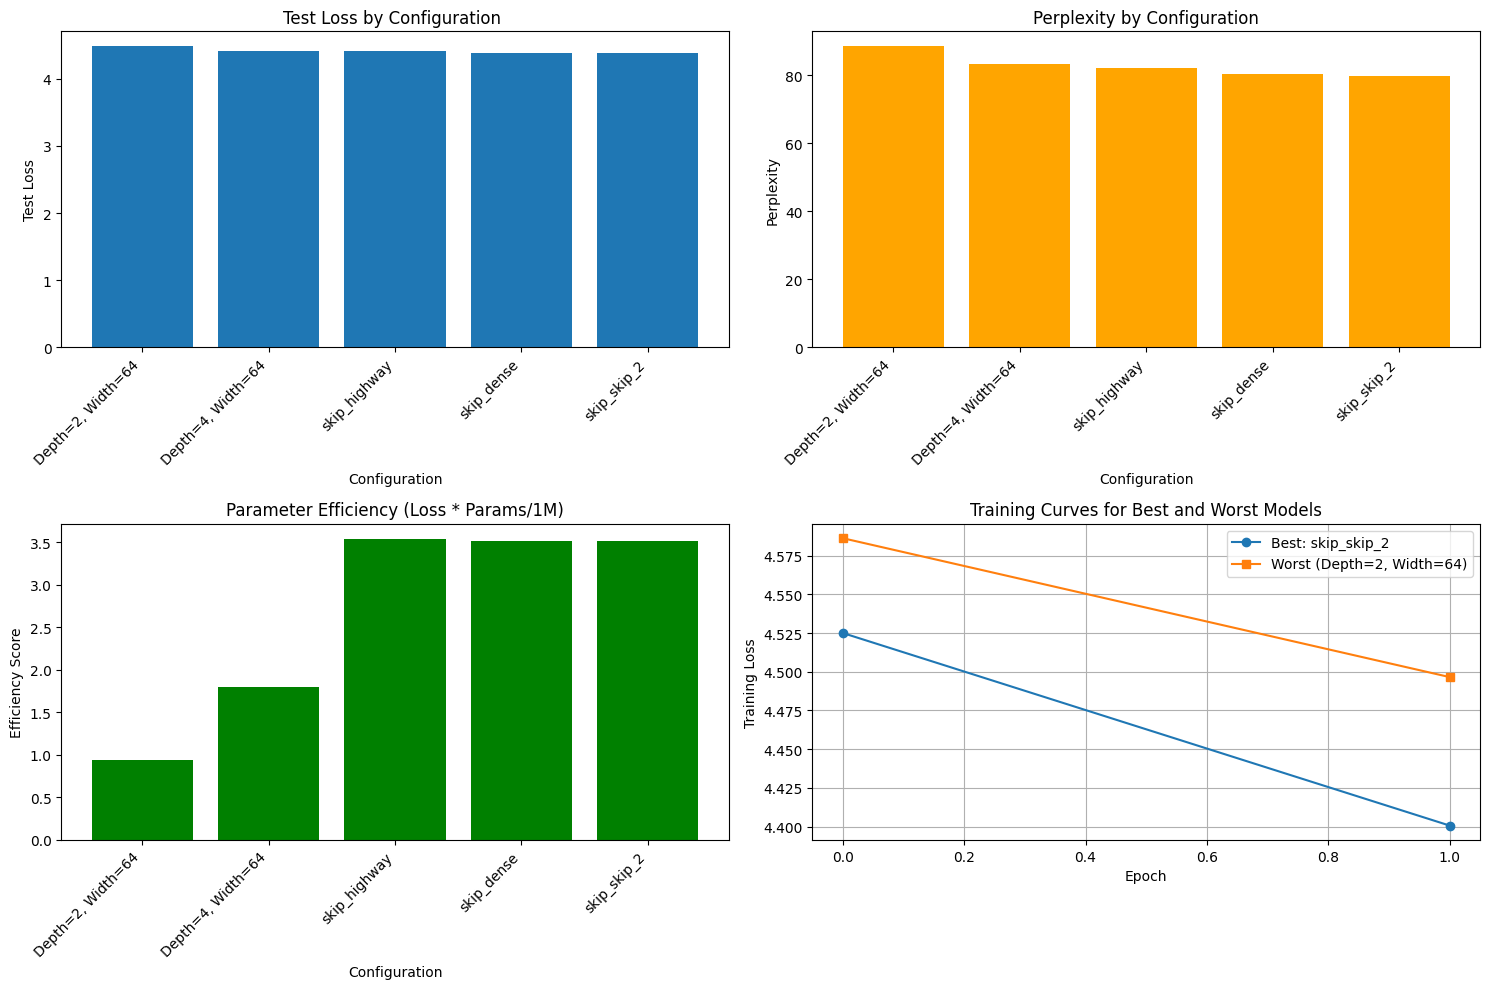


Experiment Results Summary:

Depth=2, Width=64:
Test Loss: 4.4825
Perplexity: 88.46
Parameters: 209,920
Final Training Loss: 4.4965

Depth=4, Width=64:
Test Loss: 4.4212
Perplexity: 83.19
Parameters: 407,040
Final Training Loss: 4.4425

skip_highway:
Test Loss: 4.4085
Perplexity: 82.15
Parameters: 802,304
Final Training Loss: 4.4415

skip_dense:
Test Loss: 4.3854
Perplexity: 80.27
Parameters: 801,280
Final Training Loss: 4.4097

skip_skip_2:
Test Loss: 4.3787
Perplexity: 79.74
Parameters: 801,280
Final Training Loss: 4.4007

Best Performing Configurations:
 Lowest Test Loss: skip_skip_2 (4.3787)
 Lowest Perplexity: skip_skip_2 (79.74)
 Best Efficiency: Depth=2, Width=64 (0.94)
--- Analysis Complete ---


In [ ]:
class LayerConfigExperiment:
  def __init__(self, base_config: ModelConfig, device: str = 'cuda' if torch.cuda.is_available() else 'cpu'):
    self.base_config = base_config
    self.device = device
    self.results = {}
    self.tokenizer = SimpleTokenizer(base_config.vocab_size)

  def create_sample_data(self, num_samples: int = 1000) -> List[str]:
    # Create simple data for training
    samples = []
    for i in range(num_samples):
      # Generate simple patterns that require some learning
      length = np.random.randint(50, 200)
      sample = ''.join(np.random.choice(list("abcdefghijklmnopqrstuvwxyz .,!?"), length))
      samples.append(sample)
    return samples

  def generate_configs(self, target_params: int = 25_000_000) -> List[Tuple[str, ModelConfig]]:
    # Generate diff model configurations with similar parameter counts
    configs = []

    # Depth vs Width Configurations
    depth_width_configs = [
        (2, 64),  # Shallow and wide
        (4, 64),  # Meduim Depth
        (6, 48),  # Deep and Narrow
        #(24, 512),  # Very deep
    ]

    for n_layers, d_model in depth_width_configs:
      config = ModelConfig(
          vocab_size=self.base_config.vocab_size,
          max_seq_len=self.base_config.max_seq_len,
          n_layers=n_layers,
          n_heads=min(8, d_model // 64),   # Adjust heads based on model size
          d_model=d_model,
          d_ff= 4 * d_model,
          dropout=self.base_config.dropout

      )
      configs.append((f"Depth={n_layers}, Width={d_model}", config))

   # Bottleneck Configurations
    bottleneck_configs = [
       ("hourglass", "hourglass"),
       ("inverted", "inverted")
     ]

    for name, pattern in bottleneck_configs:
      config = ModelConfig(
          vocab_size=self.base_config.vocab_size,
          max_seq_len=self.base_config.max_seq_len,
          n_layers=8,
          n_heads=4,
          d_model=64,
          dropout=self.base_config.dropout,
          use_bottleneck=True,
          bottleneck_pattern=pattern
      )
      configs.append((f"Bottleneck={name}", config))

    # Skip Connection Configurations
    skip_configs = [
        ("highway", "highway", 1),
        ("dense", "dense", 1),
        ("skip_2", "residual", 2),
    ]

    for name, skip_type, frequency in skip_configs:
      config = ModelConfig(
          vocab_size=self.base_config.vocab_size,
          max_seq_len=self.base_config.max_seq_len,
          n_layers=8,
          n_heads=4,
          d_model=64,
          dropout=self.base_config.dropout,
          skip_connection_type=skip_type,
          skip_frequency=frequency
      )
      configs.append((f"skip_{name}", config))

    return configs

  def train_model(self, config: ModelConfig, train_data: List[str], num_epochs: int = 5, batch_size: int = 32, lr: float = 1e-4) -> Dict:
    # Train a single model configuration

    model = TransformerModel(config).to(self.device)
    dataset = SimpleDataset(train_data, self.tokenizer, config.max_seq_len)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    criterion = nn.CrossEntropyLoss(ignore_index=0)

    model.train()
    losses = []
    training_times = []

    logger.info(f"Training model with  {model.config.count_parameters():,} parameters")

    for epoch in range(num_epochs):
      epoch_loss = 0.0
      start_time = time.time()

      for batch_idx, batch in enumerate(dataloader):
        batch = batch.to(self.device)

        # Create input and target (shifted by 1)
        inputs = batch[:, :-1]
        targets = batch[:, 1:]

        optimizer.zero_grad()
        logits = model(inputs)

        # Reshape for loss Calculation
        loss = criterion(logits.reshape(-1, config.vocab_size), targets.reshape(-1))
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if batch_idx % 50 == 0:
          logger.info(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}, Loss: {loss.item():.4f}")

      epoch_time = time.time() - start_time
      avg_loss = epoch_loss / len(dataloader)

      losses.append(avg_loss)
      training_times.append(epoch_time)

      logger.info(f"Epoch {epoch+1} completed: Avg Loss = {avg_loss:.4f}, Time = {epoch_time:.2f}s")

    return {
        'model': model,
        'losses': losses,
        'training_times': training_times,
        'final_loss': losses[-1],
        'total_params': config.count_parameters(),
        'config': config
    }

  def evaluate_model(self, model: TransformerModel, test_data: List[str], batch_size: int = 32) -> Dict:
    # Evaluate Trained Model
    model.eval()
    dataset = SimpleDataset(test_data, self.tokenizer, model.config.max_seq_len)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    criterion = nn.CrossEntropyLoss(ignore_index=0)
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():
      for batch in dataloader:
        batch = batch.to(self.device)
        inputs = batch[:, :-1]
        targets = batch[:, 1:]

        logits = model(inputs)
        loss = criterion(logits.reshape(-1, logits.size(-1)), targets.reshape(-1))

        total_loss += loss.item() * batch.size(0)
        total_samples += batch.size(0)

    avg_loss = total_loss / total_samples
    perplexity = math.exp(avg_loss)

    return {
        'test_loss': avg_loss,
        'perplexity': perplexity,
    }

  def run_experiment(self, num_epochs:  int = 5, batch_size: int = 32, train_samples: int = 1000):
    # Run the complete layer configuration experiment

    #Generate training and text data
    logger.info("Generating Training Data....")
    all_data = self.create_sample_data(train_samples + 200)
    train_data = all_data[:train_samples]
    test_data = all_data[train_samples:]

    # Generate model configurations
    configs = self.generate_configs()

    logger.info(f"Running experiment with {len(configs)} configurations...")

    for config_name, config in configs:
      logger.info(f"\n{'='*50}")
      logger.info(f"Training configuration: {config_name}")
      logger.info(f"Parameters: {config.count_parameters():,}")
      logger.info(f"{'='*50}")

      try:
        # Train Model
        train_results = self.train_model(config, train_data, num_epochs, batch_size)

        # Evaluate Model
        eval_results = self.evaluate_model(train_results['model'], test_data, batch_size)

        # Store Results
        self.results[config_name] = {
            **train_results,
            **eval_results
        }

        logger.info(f"Completed {config_name}: Test Loss = {eval_results['test_loss']:.4f}, "
                    f"Perplexity = {eval_results['perplexity']:.2f}")


        # Clean up to save memory
        del train_results['model']
        torch.cuda.empty_cache() if torch.cuda.is_available() else None

      except Exception as e:
        logger.error(f"Error training {config_name}: {str(e)}")
        continue

  def analyze_results(self):
    print("--- Starting Analysis ---") # Added print statement
    # Analyze and Visualize experiment results
    if not self.results:
      logger.error("No results to analyze. Run Experiment first")
      print("--- No results to analyze ---") # Added print statement for this case
      return

    # Prepare data for analysis
    config_names = list(self.results.keys())
    test_losses = [self.results[name]['test_loss'] for name in config_names]
    perplexities = [self.results[name]['perplexity'] for name in config_names]
    param_counts = [self.results[name]['total_params'] for name in config_names]
    final_train_losses = [self.results[name]['final_loss'] for name in config_names]

    # Create Visualizations
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Test loss Comparison
    ax1.bar(range(len(config_names)), test_losses)
    ax1.set_xlabel('Configuration')
    ax1.set_ylabel('Test Loss')
    ax1.set_title('Test Loss by Configuration ')
    ax1.set_xticks(range(len(config_names)))
    ax1.set_xticklabels(config_names, rotation=45, ha='right')

    # Perplexity Comparison
    ax2.bar(range(len(config_names)), perplexities, color='orange')
    ax2.set_xlabel('Configuration')
    ax2.set_ylabel('Perplexity')
    ax2.set_title('Perplexity by Configuration')
    ax2.set_xticks(range(len(config_names)))
    ax2.set_xticklabels(config_names, rotation=45, ha='right')

    # Parameter efficiency (lower is better)
    efficiency_scores = [loss * params / 1e6 for loss, params in zip(test_losses, param_counts)]
    ax3.bar(range(len(config_names)), efficiency_scores, color='green')
    ax3.set_xlabel('Configuration')
    ax3.set_ylabel('Efficiency Score')
    ax3.set_title('Parameter Efficiency (Loss * Params/1M)')
    ax3.set_xticks(range(len(config_names)))
    ax3.set_xticklabels(config_names, rotation=45, ha='right')


    # Training curves for best and worst models
    best_idx = np.argmin(test_losses)
    worst_idx = np.argmax(test_losses)

    best_losses = self.results[config_names[best_idx]]['losses']
    worst_losses = self.results[config_names[worst_idx]]['losses']

    ax4.plot(best_losses, label=f'Best: {config_names[best_idx]}', marker='o')
    ax4.plot(worst_losses, label=f'Worst ({config_names[worst_idx]})', marker='s')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Training Loss')
    ax4.set_title('Training Curves for Best and Worst Models')
    ax4.legend()
    ax4.grid(True)

    plt.tight_layout()
    plt.savefig('layer_config_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print Summary Statistics
    print("\n" + "="*60)
    print("Experiment Results Summary:")
    print("="*60)

    for i, name in enumerate(config_names):
      print(f"\n{name}:")
      print(f"Test Loss: {test_losses[i]:.4f}")
      print(f"Perplexity: {perplexities[i]:.2f}")
      print(f"Parameters: {param_counts[i]:,}")
      print(f"Final Training Loss: {final_train_losses[i]:.4f}")

    # Best Performing configurations
    best_loss_idx = np.argmin(test_losses)
    best_ppl_idx = np.argmin(perplexities)
    best_eff_idx = np.argmin(efficiency_scores)

    print("\nBest Performing Configurations:")
    print(f" Lowest Test Loss: {config_names[best_loss_idx]} ({test_losses[best_loss_idx]:.4f})")
    print(f" Lowest Perplexity: {config_names[best_ppl_idx]} ({perplexities[best_ppl_idx]:.2f})")
    print(f" Best Efficiency: {config_names[best_eff_idx]} ({efficiency_scores[best_eff_idx]:.2f})")

    print("--- Analysis Complete ---") # Added print statement

# example Usage
# Configure base model
base_config = ModelConfig(
    vocab_size=100,
    max_seq_len=32,
    dropout=0.1
)

# Initialize Experiment
experiment = LayerConfigExperiment(base_config)

# Run Experiment
experiment.run_experiment(num_epochs=2, batch_size=4, train_samples=25)

# Analyze Results
experiment.analyze_results()